This notebook reads one (or more) OTEANN results file(s) and vizualises them

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import codecs

def get_unique_chars(filename):
    unique_chars = set(char for line in codecs.open(filename, encoding="UTF-8") for char in line)
    return unique_chars

def display_orthography_letters(config):

    languages = config['languages']

    for lang in languages:
        filename = config['root_dir'] + '/' + config['subdatasets_dir'] + '/' + lang + '_' + config['subdataset']
        filename_g = filename + '_graphemes.tmp'
        filename_p = filename + '_phonemes.tmp'

        df = pd.read_csv(filename)

        df.Word.to_csv(filename_g, index=False, header=None)
        df_g = pd.read_csv(filename_g)

        df.Pronunciation.to_csv(filename_p, index=False, header=None)
        df_p = pd.read_csv(filename_p)

        unique_graphemes = get_unique_chars(filename_g)
        unique_phonemes = get_unique_chars(filename_p)
        
        os.remove(filename_g)
        os.remove(filename_p)
        print('%s, n_phonemes:%d, n_graphemes:%d' % (
            lang, len(unique_phonemes)-1, len(unique_graphemes)-1)) # -1 is for ''\n'
        print("graphemes:", sorted(unique_graphemes))
        print("phonemes:", sorted(unique_phonemes))
        print("-------------------------------")
#display_orthography_letters(config)

In [3]:
# These first configuration parameters are hyperparameters that we will need to tune
CONFIG = {            
    'n_train': 0,
}

ROOT_DIR = os.getcwd()

# These other configuration parameters will not be tuned
def extend_config(config): 
    config['languages'] = ['ent', 'eno','ar', 'br', 'de', 'en', 'eo', 'es', 'fi', 'fr', 'fro', 'it', 'ko', 'nl', 'pt', 'ru', 'sh', 'tr', 'zh']
    config['tasks'] = ['write', 'read']
    #config['languages'] = ['ent', 'eno', 'br', 'fr']
    #config['languages'] = ['ent']    
    config['n_test'] = 1000
    config['n_samples'] = config['n_train'] + config['n_test']
    config['label'] = 'oteann' + '_' + str(config['n_samples'])
    config['subdatasets_dir'] = 'subdatasets'
    config['subdataset'] = 'wikt_samples.csv' # postfix from fonetik.fr 
    config['root_dir'] = os.getcwd()    
    config['trial_dir'] = os.getcwd() 
    config['trial_filename'] = config['trial_dir'] + '/' + config['label']
    config['results_filename'] = config['trial_filename'] + '_results.csv'
    return config
        
config = extend_config(CONFIG)

In [4]:
def display_textual_results(config):
    df_results = pd.read_csv(config['results_filename']) 
    # display the "write" results of the different languages
    # the best writing-system is on the first line
    # the worst writing-system is on the last line
    print('scoring of the orthograpies with respect to "write" task:')
    print(df_results[df_results.task == 'write'].sort_values('test_accuracy', ascending=False))
    print()
    # display the "read" results of the different languages
    # the best reading-system is on the first line
    # the worst reading-system is on the last line
    print('scoring of the orthograpies with respect to "read" task:')
    print(df_results[df_results.task == 'read'].sort_values('test_accuracy', ascending=False))

In [5]:
def display_text_results(config):
    df_results = pd.read_csv(config['results_filename']) 
    # display the "write" results oe the different languages
    print("|-----------|------------|------------|")
    print("|orthography| write score| read score |")
    print("|-----------|------------|------------|")
    for lang in df_results.lang.unique():
        dfl = df_results[df_results.lang == lang]
        print("|    %3s    | %04.1f ± %2.1f | %04.1f ± %2.1f |" % (
              lang.ljust(3),
              round(dfl[dfl.task == 'write'].mean()*100, 1),
              round(dfl[dfl.task == 'write'].std()*100, 1),
              round(dfl[dfl.task == 'read'].mean()*100, 1),
              round(dfl[dfl.task == 'read'].std()*100, 1))
             )
        if lang == 'eno':
            print("|-----------|------------|------------|")
    print("|-----------|------------|------------|")

In [6]:
def display_latex_results(config):

    print('\\begin{figure}[h]')
    print('\centering')
    print('\captionsetup{justification=centering}')
    print('\\begin{floatrow}')
    print('\\capbtabbox{%')
    print('\\begin{tabular}{c c c}')
    print('\\hline')
    print('\\textbf{Language} & \\textbf{Write} & \\textbf{Read}\\\\')
    print('\\hline\hline')
    
    df_results = pd.read_csv(config['results_filename']) 
    # display the "write" results oe the different languages
    n = config['n_train']
    
    for lang in df_results.lang.unique():
        dfl = df_results[df_results.lang == lang]
        print("%s & %4.1f ± %2.1f & %4.1f ± %2.1f \\\\\\hline" % (
              lang.ljust(3),
              round(dfl[dfl.task == 'write'].mean()*100, 1),
              round(dfl[dfl.task == 'write'].std()*100, 1),
              round(dfl[dfl.task == 'read'].mean()*100, 1),
              round(dfl[dfl.task == 'read'].std()*100, 1))
             )
        if lang == 'eno':
            print('\\hline')  
    print('\\end{tabular}')
    print('}{%')
    print('  \\caption{Phonemic transparency scores. \\newline ' + 
          '(OTEANN trained with $' + f'{n:,}' + '$ samples)}%')
    print('  \\label{tab:tabular_results_' + str(config['n_samples']) + '}')
    print('}')
    print('\\ffigbox{%')
    print('\\includegraphics[width=7.5cm]{oteann_' + 
          str(config['n_samples']) + '_results.png}%')
    print('}{%')
    print('  \\caption{Scatterplot of the mean scores. \\newline ' + 
          '(OTEANN trained with $' + f'{n:,}' + '$ samples)}%')
    print('  \\label{fig:figure_results_' + str(config['n_samples']) + '}')
    print('}')
    print('\\end{floatrow}')
    print('\\end{figure}')

In [7]:
def display_barplot_results(config):
    
    df = pd.read_csv(config['results_filename'])
    
    sns.set(style="whitegrid")
    current_palette = sns.color_palette()
    for task in config['tasks']:
        df_o = df[df.task==task].sort_values(by='lang')
        df_o = df_o[['task', 'lang', 'test_accuracy']]
        df_o['test_accuracy']=df_o['test_accuracy']*100
        df_o = round(df_o.groupby('lang', as_index=False).mean())
        sns.palplot(current_palette)
        ax = sns.barplot(x="lang", y="test_accuracy",
                         data=df_o, palette=current_palette)
        # add the accuracy number on the top of each bar
        i=0
        for index, row in df_o.iterrows():
            ax.text(i, row.test_accuracy+1, str(round(row.test_accuracy)), color='black', ha="center")
            i+=1
        plt.title(task.capitalize())
        plt.ylim(0, 100)
        plt.show()

In [8]:
def display_boxplot_results(config):
    
    df = pd.read_csv(config['results_filename'])
    
    sns.set(style="whitegrid")
    current_palette = sns.color_palette()
    for task in config['tasks']:
        df_o = df[df.task==task].sort_values(by='lang')
        df_o = df_o[['task', 'lang', 'test_accuracy']]
        df_o['test_accuracy']=df_o['test_accuracy']*100
        #df_o = df_o.groupby('lang', as_index=False).mean()
        sns.palplot(current_palette)
        ax = sns.boxplot(x="lang", y="test_accuracy",
                         data=df_o, palette=current_palette)
        # add the accuracy number on the top of each bar
        i=0
        for index, row in df_o.iterrows():
            #ax.text(i, row.test_accuracy+1, str(round(row.test_accuracy)), color='black', ha="center")
            i+=1
        plt.title(task.capitalize())
        plt.ylim(0, 100)
        plt.show()

In [9]:
def display_config(config):
    n = config['n_train']
    print('n_train:', f'{n:,}')
    df_results = pd.read_csv(config['results_filename'])
    n_tasks = len(df_results['task'].unique())
    n_langs = len(df_results['lang'].unique())
    print('result file:')
    print('* n_tasks: %d' % n_tasks)
    print('* n_langs: %d' % n_langs)
    print('* n_rows: %d' % df_results.shape[0])
    if n_tasks > 0 and n_langs > 0:
        nb_episodes = float(df_results.shape[0]) / (n_tasks * n_langs)
        print('* nb_episodes: %.2f' % nb_episodes)

In [10]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+2, point['y'], str(point['val']))

def display_scatterplot_results(config):
    
    df_results = pd.read_csv(config['results_filename']) 
    
    df_results = df_results[~df_results['lang'].str.contains('eno')]
    df_results = df_results[~df_results['lang'].str.contains('ent')]
    
    df_results = df_results.groupby(['lang','task'], as_index=False).mean()
    
    df_w = df_results[df_results.task=='write']
    df_w.rename(columns={"task": "write"})
    df_r = df_results[df_results.task=='read']
    df_r.rename(columns={"task": "read"})

    df_res = df_w.merge(df_r, left_on='lang', right_on='lang')
    df_res = df_res.rename(columns={"test_accuracy_x": "write_accuracy", "test_accuracy_y": "read_accuracy"})
    df_res['write_accuracy'] = df_res['write_accuracy'] * 100
    df_res['read_accuracy'] = df_res['read_accuracy'] * 100

    sns.set_theme(color_codes=True)
    
    ax = sns.lmplot(
        data=df_res, # Data source
        x='write_accuracy',
        y='read_accuracy',
        fit_reg=False, # Don't fix a regression line
        height=5,
        aspect=1) # size and dimension
    
    
    #plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    
    #plt.title('Transparency of the orthographies (with %d training samples)' % config['n_train'])
    # Set x-axis label
    plt.xlabel('Write accuracy')
    # Set y-axis label
    plt.ylabel('Read accuracy')
    
    label_point(df_res.write_accuracy, df_res.read_accuracy, df_res.lang, plt.gca())
    
    ax.set(xlim=(-1.5, 101.5))
    ax.set(ylim=(-1.5, 101.5))        

    #plt.subplots_adjust(left=-0.1, bottom=-0.1, right=1.05, top=1.05)
    plt.tight_layout()
    figure_file = 'oteann_' + str(config['n_samples']) + '_results.png'
    plt.show()
    plt.savefig(figure_file)

In [11]:
def display_aggregated_scatterplot_results(config, n_trains):    
    
    #sns.set(rc={'figure.figsize':(6.5, 6.5)})
    sns.set(rc={'figure.figsize':(7, 7)})
    #plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    
    df_res = pd.DataFrame(columns=['n_train', 'orthography', 'write_accuracy', 'read_accuracy'])    
    
    for n_train in n_trains:
        config['n_train'] = n_train
        config = extend_config(config)
        df_results = pd.read_csv(config['results_filename']) 
        
        df_results = df_results[~df_results['lang'].str.contains('eno')]
        df_results = df_results[~df_results['lang'].str.contains('ent')]

        df_results = df_results.rename(columns={'lang': 'orthography'})
        df_results = df_results.groupby(['orthography','task'], as_index=False).mean()

        df_w = df_results[df_results.task=='write']
        df_w.rename(columns={"task": "write"})
        df_r = df_results[df_results.task=='read']
        df_r.rename(columns={"task": "read"})
        
        df_res_i = df_w.merge(df_r, left_on='orthography', right_on='orthography')
        df_res_i = df_res_i.rename(columns={"test_accuracy_x": "write_accuracy", "test_accuracy_y": "read_accuracy"})
        df_res_i = df_res_i.drop(columns=['task_x', 'task_y'])
        df_res_i['n_train'] = n_train

        df_res = df_res.append(df_res_i)
    df_res = df_res.rename(columns={'n_train': 'Training samples'})
    df_res = df_res.rename(columns={'orthography': 'Orthography'})
        
    ax = sns.scatterplot(
        data=df_res, # Data source
        x='write_accuracy',
        y='read_accuracy',
        hue='Orthography',
        size='Training samples',
        #alpha=0.70,
        legend='full',
        size_order=[1000, 2000, 3000, 5000, 10000]
    )

    #plt.title('Transparency of the orthographies (with %d training samples)' % config['n_train'])
    # Set x-axis label
    plt.xlabel('Write accuracy')
    # Set y-axis label
    plt.ylabel('Read accuracy')

    
    
    #df_res_last = df_res[df_res.n_train == n_trains[-1]]
    #label_point(df_res_last.write_accuracy, df_res_last.read_accuracy, df_res_last.lang, plt.gca())

    ax.set(xlim=(-0.01, 1.015))
    ax.set(ylim=(-0.01, 1.015))
    #plt.figure(figsize=(150, 150))
    
    
    #handles, labels = ax.legend_elements(prop="lang", alpha=0.6)
    #legend2 = ax.legend(handles, labels, loc="upper right", title="Orthography")

    plt.subplots_adjust(left=-0.2, bottom=-0.1, right=1.05, top=1.05)
    plt.tight_layout()
    plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    figure_file = 'oteann_results.png'
    plt.show()
    plt.savefig(figure_file)

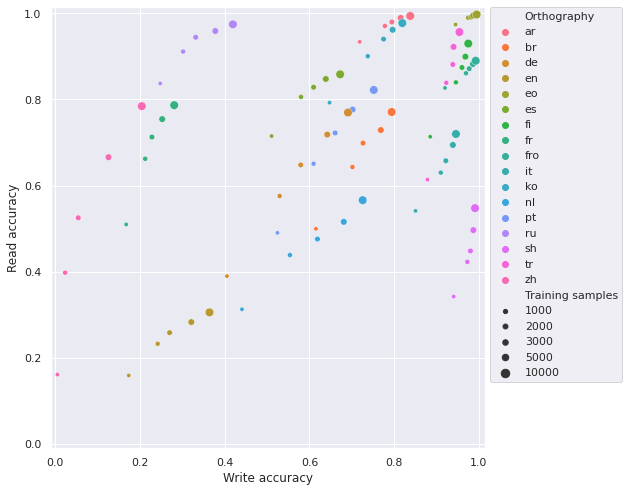

<Figure size 504x504 with 0 Axes>

In [12]:
n_trains = [1000, 2000, 3000, 5000, 10000]

for n_train in n_trains:
    config['n_train'] = n_train
    config = extend_config(config)
display_aggregated_scatterplot_results(config, n_trains)

########################################


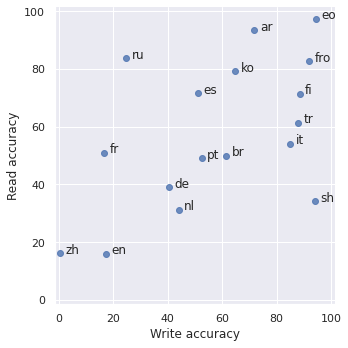

########################################


<Figure size 504x504 with 0 Axes>

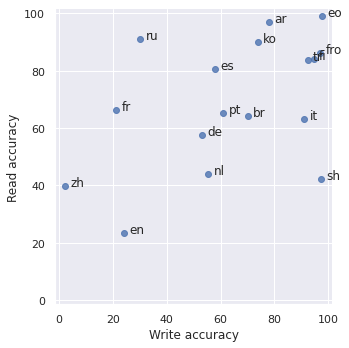

########################################


<Figure size 504x504 with 0 Axes>

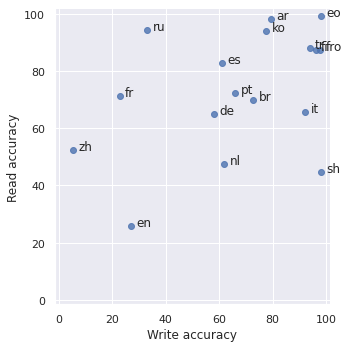

########################################


<Figure size 504x504 with 0 Axes>

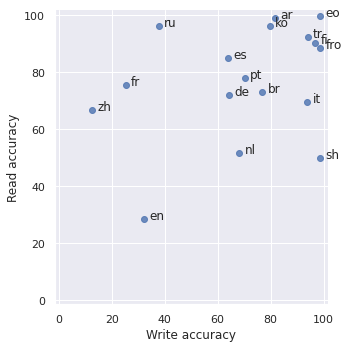

########################################


<Figure size 504x504 with 0 Axes>

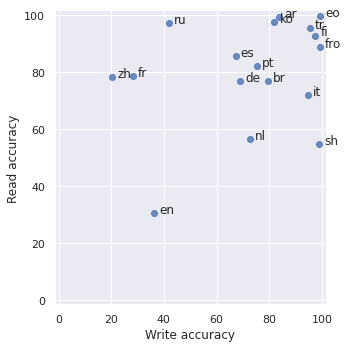

<Figure size 504x504 with 0 Axes>

In [13]:
results = [1000, 2000, 3000, 5000, 10000]

for n_train in results:
    print('########################################')
    config = { 
        'n_train': n_train
    }
    config = extend_config(config)
    display_scatterplot_results(config)

########################################
n_train: 1,000
result file:
* n_tasks: 2
* n_langs: 19
* n_rows: 418
* nb_episodes: 11.00
|-----------|------------|------------|
|orthography| write score| read score |
|-----------|------------|------------|
|    ent    | 95.0 ± 1.9 | 97.2 ± 0.6 |
|    eno    | 00.0 ± 0.0 | 00.0 ± 0.0 |
|-----------|------------|------------|
|    ar     | 71.9 ± 0.9 | 93.3 ± 0.9 |
|    br     | 61.5 ± 2.2 | 49.9 ± 2.0 |
|    de     | 40.5 ± 2.0 | 39.0 ± 2.8 |
|    en     | 17.3 ± 2.0 | 15.9 ± 1.4 |
|    eo     | 94.5 ± 1.2 | 97.4 ± 0.4 |
|    es     | 51.1 ± 2.8 | 71.5 ± 2.7 |
|    fi     | 88.5 ± 1.5 | 71.3 ± 2.5 |
|    fr     | 16.7 ± 1.1 | 51.0 ± 3.5 |
|    fro    | 92.0 ± 1.3 | 82.6 ± 0.9 |
|    it     | 85.0 ± 2.4 | 54.1 ± 2.5 |
|    ko     | 64.7 ± 1.9 | 79.2 ± 2.2 |
|    nl     | 44.1 ± 1.8 | 31.3 ± 2.9 |
|    pt     | 52.4 ± 2.0 | 49.0 ± 2.9 |
|    ru     | 24.8 ± 1.6 | 83.7 ± 1.8 |
|    sh     | 94.0 ± 0.7 | 34.2 ± 2.1 |
|    tr     | 87.8 ± 1.7 | 61

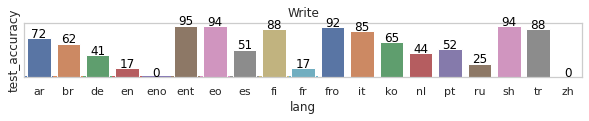

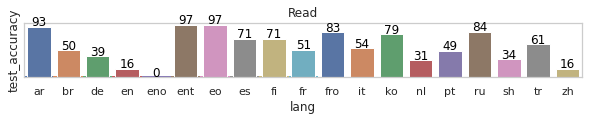

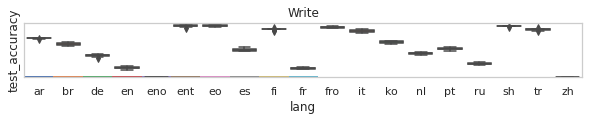

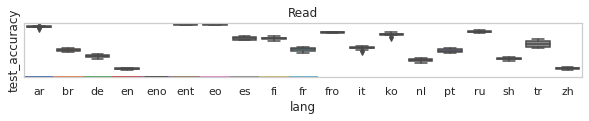

\begin{figure}[h]
\centering
\captionsetup{justification=centering}
\begin{floatrow}
\capbtabbox{%
\begin{tabular}{c c c}
\hline
\textbf{Language} & \textbf{Write} & \textbf{Read}\\
\hline\hline
ent & 95.0 ± 1.9 & 97.2 ± 0.6 \\\hline
eno &  0.0 ± 0.0 &  0.0 ± 0.0 \\\hline
\hline
ar  & 71.9 ± 0.9 & 93.3 ± 0.9 \\\hline
br  & 61.5 ± 2.2 & 49.9 ± 2.0 \\\hline
de  & 40.5 ± 2.0 & 39.0 ± 2.8 \\\hline
en  & 17.3 ± 2.0 & 15.9 ± 1.4 \\\hline
eo  & 94.5 ± 1.2 & 97.4 ± 0.4 \\\hline
es  & 51.1 ± 2.8 & 71.5 ± 2.7 \\\hline
fi  & 88.5 ± 1.5 & 71.3 ± 2.5 \\\hline
fr  & 16.7 ± 1.1 & 51.0 ± 3.5 \\\hline
fro & 92.0 ± 1.3 & 82.6 ± 0.9 \\\hline
it  & 85.0 ± 2.4 & 54.1 ± 2.5 \\\hline
ko  & 64.7 ± 1.9 & 79.2 ± 2.2 \\\hline
nl  & 44.1 ± 1.8 & 31.3 ± 2.9 \\\hline
pt  & 52.4 ± 2.0 & 49.0 ± 2.9 \\\hline
ru  & 24.8 ± 1.6 & 83.7 ± 1.8 \\\hline
sh  & 94.0 ± 0.7 & 34.2 ± 2.1 \\\hline
tr  & 87.8 ± 1.7 & 61.4 ± 6.2 \\\hline
zh  &  0.5 ± 0.2 & 16.1 ± 1.8 \\\hline
\end{tabular}
}{%
  \caption{Phonemic transparency scores

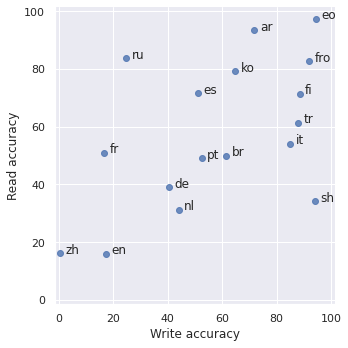

########################################
########################################
n_train: 2,000
result file:
* n_tasks: 2
* n_langs: 19
* n_rows: 418
* nb_episodes: 11.00
|-----------|------------|------------|
|orthography| write score| read score |
|-----------|------------|------------|
|    ent    | 98.0 ± 1.0 | 98.9 ± 0.3 |
|    eno    | 00.0 ± 0.0 | 00.0 ± 0.0 |
|-----------|------------|------------|
|    ar     | 77.8 ± 1.6 | 97.0 ± 0.7 |
|    br     | 70.1 ± 1.7 | 64.3 ± 1.8 |
|    de     | 53.0 ± 1.8 | 57.6 ± 2.3 |
|    en     | 24.2 ± 1.5 | 23.3 ± 1.6 |
|    eo     | 97.5 ± 0.9 | 98.9 ± 0.4 |
|    es     | 58.0 ± 1.8 | 80.6 ± 1.7 |
|    fi     | 94.6 ± 1.0 | 83.9 ± 1.6 |
|    fr     | 21.2 ± 1.5 | 66.2 ± 1.9 |
|    fro    | 96.9 ± 1.3 | 86.1 ± 1.1 |
|    it     | 91.0 ± 0.9 | 63.0 ± 1.8 |
|    ko     | 73.8 ± 1.3 | 90.0 ± 0.8 |
|    nl     | 55.4 ± 1.5 | 43.9 ± 2.4 |
|    pt     | 61.0 ± 1.5 | 65.1 ± 1.8 |
|    ru     | 30.2 ± 1.3 | 91.1 ± 1.1 |
|    sh     | 97.3 ± 0.6 | 4

<Figure size 504x504 with 0 Axes>

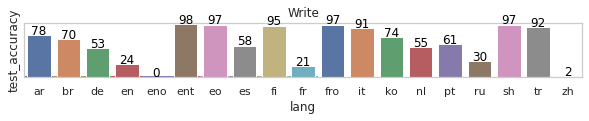

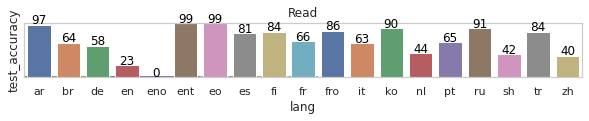

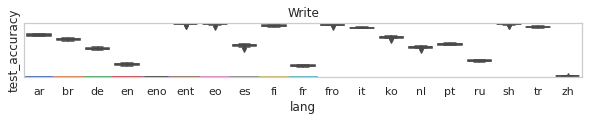

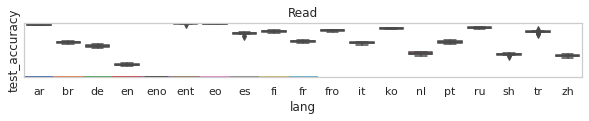

\begin{figure}[h]
\centering
\captionsetup{justification=centering}
\begin{floatrow}
\capbtabbox{%
\begin{tabular}{c c c}
\hline
\textbf{Language} & \textbf{Write} & \textbf{Read}\\
\hline\hline
ent & 98.0 ± 1.0 & 98.9 ± 0.3 \\\hline
eno &  0.0 ± 0.0 &  0.0 ± 0.0 \\\hline
\hline
ar  & 77.8 ± 1.6 & 97.0 ± 0.7 \\\hline
br  & 70.1 ± 1.7 & 64.3 ± 1.8 \\\hline
de  & 53.0 ± 1.8 & 57.6 ± 2.3 \\\hline
en  & 24.2 ± 1.5 & 23.3 ± 1.6 \\\hline
eo  & 97.5 ± 0.9 & 98.9 ± 0.4 \\\hline
es  & 58.0 ± 1.8 & 80.6 ± 1.7 \\\hline
fi  & 94.6 ± 1.0 & 83.9 ± 1.6 \\\hline
fr  & 21.2 ± 1.5 & 66.2 ± 1.9 \\\hline
fro & 96.9 ± 1.3 & 86.1 ± 1.1 \\\hline
it  & 91.0 ± 0.9 & 63.0 ± 1.8 \\\hline
ko  & 73.8 ± 1.3 & 90.0 ± 0.8 \\\hline
nl  & 55.4 ± 1.5 & 43.9 ± 2.4 \\\hline
pt  & 61.0 ± 1.5 & 65.1 ± 1.8 \\\hline
ru  & 30.2 ± 1.3 & 91.1 ± 1.1 \\\hline
sh  & 97.3 ± 0.6 & 42.3 ± 1.4 \\\hline
tr  & 92.3 ± 1.0 & 83.8 ± 2.1 \\\hline
zh  &  2.3 ± 0.6 & 39.8 ± 1.9 \\\hline
\end{tabular}
}{%
  \caption{Phonemic transparency scores

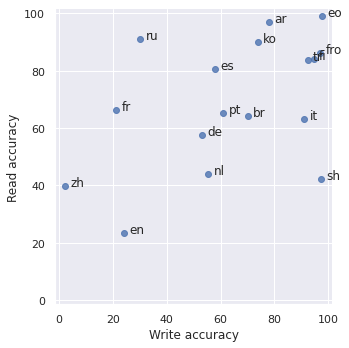

########################################
########################################
n_train: 3,000
result file:
* n_tasks: 2
* n_langs: 19
* n_rows: 418
* nb_episodes: 11.00
|-----------|------------|------------|
|orthography| write score| read score |
|-----------|------------|------------|
|    ent    | 98.6 ± 1.2 | 99.4 ± 0.3 |
|    eno    | 00.0 ± 0.0 | 00.0 ± 0.0 |
|-----------|------------|------------|
|    ar     | 79.4 ± 1.3 | 98.0 ± 0.4 |
|    br     | 72.6 ± 1.8 | 69.8 ± 1.8 |
|    de     | 57.9 ± 2.3 | 64.8 ± 2.1 |
|    en     | 27.0 ± 1.3 | 25.8 ± 1.5 |
|    eo     | 98.1 ± 0.7 | 99.1 ± 0.4 |
|    es     | 61.0 ± 1.4 | 82.8 ± 1.4 |
|    fi     | 96.0 ± 0.7 | 87.4 ± 0.8 |
|    fr     | 22.8 ± 1.6 | 71.2 ± 2.6 |
|    fro    | 97.7 ± 0.4 | 87.1 ± 0.9 |
|    it     | 92.2 ± 1.1 | 65.7 ± 1.3 |
|    ko     | 77.5 ± 1.0 | 94.0 ± 0.9 |
|    nl     | 61.9 ± 1.5 | 47.6 ± 2.0 |
|    pt     | 66.1 ± 1.4 | 72.2 ± 1.4 |
|    ru     | 33.1 ± 1.9 | 94.4 ± 0.4 |
|    sh     | 98.0 ± 0.6 | 4

<Figure size 504x504 with 0 Axes>

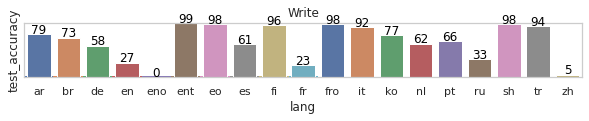

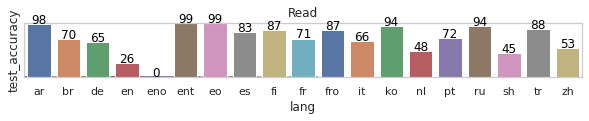

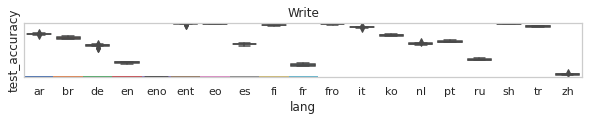

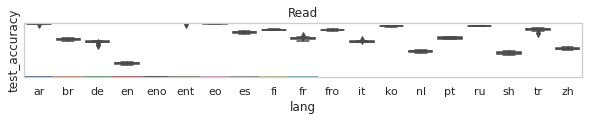

\begin{figure}[h]
\centering
\captionsetup{justification=centering}
\begin{floatrow}
\capbtabbox{%
\begin{tabular}{c c c}
\hline
\textbf{Language} & \textbf{Write} & \textbf{Read}\\
\hline\hline
ent & 98.6 ± 1.2 & 99.4 ± 0.3 \\\hline
eno &  0.0 ± 0.0 &  0.0 ± 0.0 \\\hline
\hline
ar  & 79.4 ± 1.3 & 98.0 ± 0.4 \\\hline
br  & 72.6 ± 1.8 & 69.8 ± 1.8 \\\hline
de  & 57.9 ± 2.3 & 64.8 ± 2.1 \\\hline
en  & 27.0 ± 1.3 & 25.8 ± 1.5 \\\hline
eo  & 98.1 ± 0.7 & 99.1 ± 0.4 \\\hline
es  & 61.0 ± 1.4 & 82.8 ± 1.4 \\\hline
fi  & 96.0 ± 0.7 & 87.4 ± 0.8 \\\hline
fr  & 22.8 ± 1.6 & 71.2 ± 2.6 \\\hline
fro & 97.7 ± 0.4 & 87.1 ± 0.9 \\\hline
it  & 92.2 ± 1.1 & 65.7 ± 1.3 \\\hline
ko  & 77.5 ± 1.0 & 94.0 ± 0.9 \\\hline
nl  & 61.9 ± 1.5 & 47.6 ± 2.0 \\\hline
pt  & 66.1 ± 1.4 & 72.2 ± 1.4 \\\hline
ru  & 33.1 ± 1.9 & 94.4 ± 0.4 \\\hline
sh  & 98.0 ± 0.6 & 44.8 ± 2.6 \\\hline
tr  & 93.8 ± 0.7 & 88.1 ± 2.9 \\\hline
zh  &  5.4 ± 1.0 & 52.5 ± 1.6 \\\hline
\end{tabular}
}{%
  \caption{Phonemic transparency scores

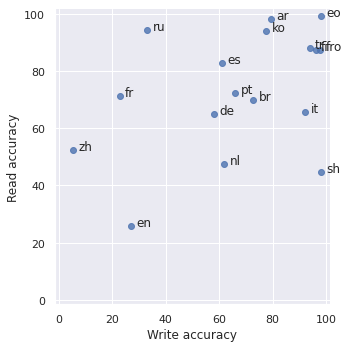

########################################
########################################
n_train: 5,000
result file:
* n_tasks: 2
* n_langs: 19
* n_rows: 418
* nb_episodes: 11.00
|-----------|------------|------------|
|orthography| write score| read score |
|-----------|------------|------------|
|    ent    | 99.4 ± 0.5 | 99.6 ± 0.3 |
|    eno    | 00.0 ± 0.0 | 00.0 ± 0.0 |
|-----------|------------|------------|
|    ar     | 81.5 ± 1.3 | 98.9 ± 0.3 |
|    br     | 76.8 ± 1.8 | 72.9 ± 1.6 |
|    de     | 64.2 ± 1.4 | 71.8 ± 1.8 |
|    en     | 32.1 ± 1.0 | 28.3 ± 1.8 |
|    eo     | 98.6 ± 0.4 | 99.4 ± 0.4 |
|    es     | 63.9 ± 1.4 | 84.7 ± 1.4 |
|    fi     | 96.8 ± 0.5 | 89.9 ± 0.8 |
|    fr     | 25.2 ± 1.6 | 75.4 ± 2.2 |
|    fro    | 98.6 ± 0.3 | 88.2 ± 1.1 |
|    it     | 93.9 ± 0.7 | 69.4 ± 1.6 |
|    ko     | 79.6 ± 1.3 | 96.1 ± 0.6 |
|    nl     | 68.1 ± 1.7 | 51.6 ± 1.3 |
|    pt     | 70.2 ± 1.6 | 77.6 ± 2.1 |
|    ru     | 37.8 ± 1.9 | 95.9 ± 1.0 |
|    sh     | 98.7 ± 0.2 | 4

<Figure size 504x504 with 0 Axes>

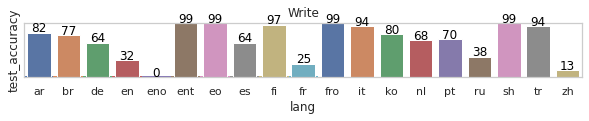

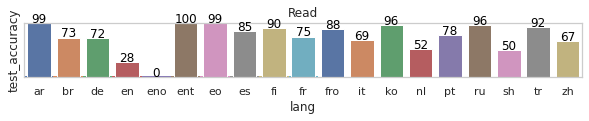

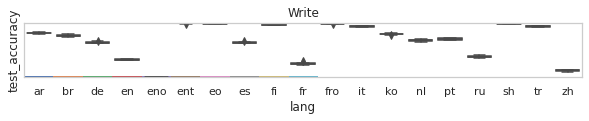

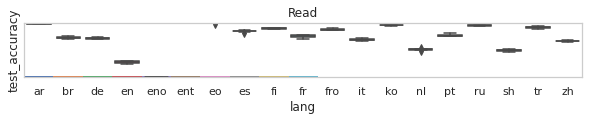

\begin{figure}[h]
\centering
\captionsetup{justification=centering}
\begin{floatrow}
\capbtabbox{%
\begin{tabular}{c c c}
\hline
\textbf{Language} & \textbf{Write} & \textbf{Read}\\
\hline\hline
ent & 99.4 ± 0.5 & 99.6 ± 0.3 \\\hline
eno &  0.0 ± 0.0 &  0.0 ± 0.0 \\\hline
\hline
ar  & 81.5 ± 1.3 & 98.9 ± 0.3 \\\hline
br  & 76.8 ± 1.8 & 72.9 ± 1.6 \\\hline
de  & 64.2 ± 1.4 & 71.8 ± 1.8 \\\hline
en  & 32.1 ± 1.0 & 28.3 ± 1.8 \\\hline
eo  & 98.6 ± 0.4 & 99.4 ± 0.4 \\\hline
es  & 63.9 ± 1.4 & 84.7 ± 1.4 \\\hline
fi  & 96.8 ± 0.5 & 89.9 ± 0.8 \\\hline
fr  & 25.2 ± 1.6 & 75.4 ± 2.2 \\\hline
fro & 98.6 ± 0.3 & 88.2 ± 1.1 \\\hline
it  & 93.9 ± 0.7 & 69.4 ± 1.6 \\\hline
ko  & 79.6 ± 1.3 & 96.1 ± 0.6 \\\hline
nl  & 68.1 ± 1.7 & 51.6 ± 1.3 \\\hline
pt  & 70.2 ± 1.6 & 77.6 ± 2.1 \\\hline
ru  & 37.8 ± 1.9 & 95.9 ± 1.0 \\\hline
sh  & 98.7 ± 0.2 & 49.6 ± 2.1 \\\hline
tr  & 94.0 ± 0.7 & 92.2 ± 1.6 \\\hline
zh  & 12.6 ± 1.2 & 66.6 ± 1.1 \\\hline
\end{tabular}
}{%
  \caption{Phonemic transparency scores

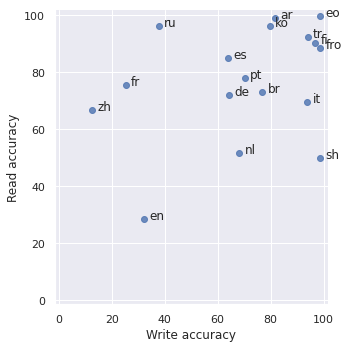

########################################
########################################
n_train: 10,000
result file:
* n_tasks: 2
* n_langs: 19
* n_rows: 418
* nb_episodes: 11.00
|-----------|------------|------------|
|orthography| write score| read score |
|-----------|------------|------------|
|    ent    | 99.8 ± 0.1 | 99.8 ± 0.2 |
|    eno    | 00.0 ± 0.0 | 00.0 ± 0.0 |
|-----------|------------|------------|
|    ar     | 83.8 ± 1.4 | 99.4 ± 0.2 |
|    br     | 79.4 ± 1.7 | 77.1 ± 1.1 |
|    de     | 69.1 ± 1.7 | 76.9 ± 1.0 |
|    en     | 36.4 ± 1.3 | 30.6 ± 1.0 |
|    eo     | 99.5 ± 0.3 | 99.7 ± 0.2 |
|    es     | 67.2 ± 1.4 | 85.8 ± 0.7 |
|    fi     | 97.5 ± 0.5 | 92.9 ± 0.7 |
|    fr     | 28.1 ± 1.7 | 78.6 ± 0.8 |
|    fro    | 99.2 ± 0.2 | 89.0 ± 0.9 |
|    it     | 94.6 ± 1.0 | 72.0 ± 1.9 |
|    ko     | 81.9 ± 1.1 | 97.7 ± 0.4 |
|    nl     | 72.6 ± 1.5 | 56.6 ± 1.8 |
|    pt     | 75.2 ± 1.6 | 82.2 ± 1.2 |
|    ru     | 41.9 ± 1.3 | 97.4 ± 0.7 |
|    sh     | 99.1 ± 0.3 | 

<Figure size 504x504 with 0 Axes>

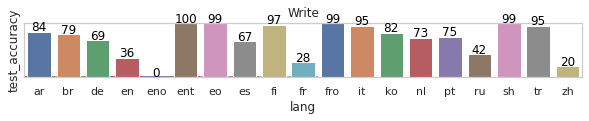

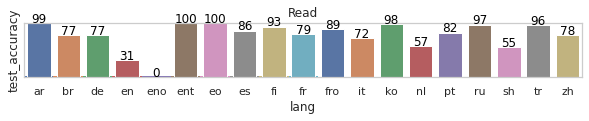

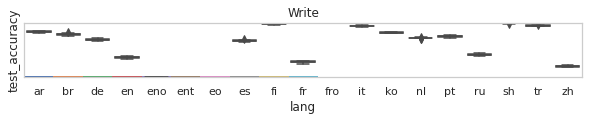

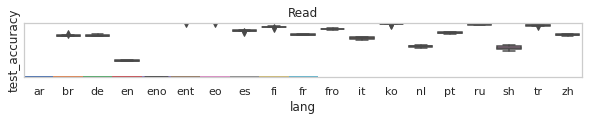

\begin{figure}[h]
\centering
\captionsetup{justification=centering}
\begin{floatrow}
\capbtabbox{%
\begin{tabular}{c c c}
\hline
\textbf{Language} & \textbf{Write} & \textbf{Read}\\
\hline\hline
ent & 99.8 ± 0.1 & 99.8 ± 0.2 \\\hline
eno &  0.0 ± 0.0 &  0.0 ± 0.0 \\\hline
\hline
ar  & 83.8 ± 1.4 & 99.4 ± 0.2 \\\hline
br  & 79.4 ± 1.7 & 77.1 ± 1.1 \\\hline
de  & 69.1 ± 1.7 & 76.9 ± 1.0 \\\hline
en  & 36.4 ± 1.3 & 30.6 ± 1.0 \\\hline
eo  & 99.5 ± 0.3 & 99.7 ± 0.2 \\\hline
es  & 67.2 ± 1.4 & 85.8 ± 0.7 \\\hline
fi  & 97.5 ± 0.5 & 92.9 ± 0.7 \\\hline
fr  & 28.1 ± 1.7 & 78.6 ± 0.8 \\\hline
fro & 99.2 ± 0.2 & 89.0 ± 0.9 \\\hline
it  & 94.6 ± 1.0 & 72.0 ± 1.9 \\\hline
ko  & 81.9 ± 1.1 & 97.7 ± 0.4 \\\hline
nl  & 72.6 ± 1.5 & 56.6 ± 1.8 \\\hline
pt  & 75.2 ± 1.6 & 82.2 ± 1.2 \\\hline
ru  & 41.9 ± 1.3 & 97.4 ± 0.7 \\\hline
sh  & 99.1 ± 0.3 & 54.8 ± 3.3 \\\hline
tr  & 95.4 ± 0.6 & 95.6 ± 0.8 \\\hline
zh  & 20.4 ± 1.3 & 78.4 ± 1.1 \\\hline
\end{tabular}
}{%
  \caption{Phonemic transparency scores

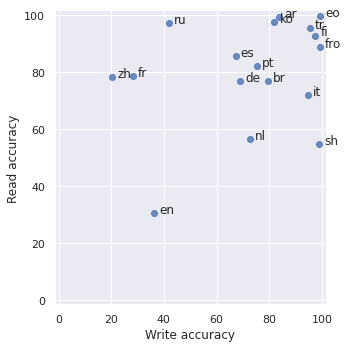

########################################


<Figure size 504x504 with 0 Axes>

In [14]:
results = [1000, 2000, 3000, 5000, 10000]

for n_train in results:
    print('########################################')
    config = { 
        'n_train': n_train
    }
    config = extend_config(config)
    #display_textual_results(config)
    display_config(config)
    display_text_results(config)
    display_barplot_results(config)
    display_boxplot_results(config)
    display_latex_results(config)
    display_scatterplot_results(config)
    print('########################################')

In [15]:
def summarizes_dataset(language, debug=False):
    if debug:
        print('lang:', language)
    result = {
        'language' : language
    }
    df = pd.read_csv('subdatasets/'+ language +'_wikt_samples.csv')
    if debug:
        print('df.shape:', df.shape)
        print(df.head(3))
    word_chars = ''.join(df['Word'].values)
    pron_chars = ''.join(df['Pronunciation'].values)
    wtoi = { ch:i for i,ch in enumerate(word_chars) }
    ptoi = { ch:i for i,ch in enumerate(pron_chars) }
    if debug:
        print('wtoi:', wtoi)
        print('')
        print('ptoi:', ptoi)
    result['n_rows'] = df.shape[0]
    samples = df.shape[0]
    result['n_phonemes'] = len(ptoi)
    result['n_graphemes'] = len(wtoi)
    df['Word_len'] = df['Word'].str.len()
    df['Pron_len'] = df['Pronunciation'].str.len()
    result['phonemes_mean_len'] = int(df['Pron_len'].mean()*10)/10
    result['phonemes_mean_std'] = int(df['Pron_len'].std()*10)/10
    result['graphemes_mean_len'] = int(df['Word_len'].mean()*10)/10
    result['graphemes_mean_std'] = int(df['Word_len'].std()*10)/10
    
    latex_str = language + ' & ' +  \
                f'{samples:,}' + ' & ' +  \
                str(result['n_phonemes']) + ' & ' +  \
                str(result['n_graphemes']) + ' & ' +  \
                str(result['phonemes_mean_len']) + ' ± ' + str(result['phonemes_mean_std']) + ' & ' +  \
                str(result['graphemes_mean_len']) + ' ± ' + str(result['graphemes_mean_std']) + ' \\\\' 
    print(latex_str)
    
    return result

In [16]:
res_datasets = []
languages = ['ar', 'br', 'de', 'en', 'eo', 'es', 'fi', 'fr', 'fro', 
             'it', 'ko', 'nl', 'pt', 'ru', 'sh', 'tr', 'zh',
             'eno', 'ent' ]
for lang in languages:
    try:
        result = summarizes_dataset(lang)
        res_datasets.append(result)
    except:
        print('pb for:', lang)
    df_datasets = pd.DataFrame(res_datasets)
df_datasets

ar & 12,057 & 32 & 47 & 8.0 ± 2.0 & 8.9 ± 2.3 \\
br & 17,343 & 45 & 29 & 6.6 ± 1.9 & 7.5 ± 2.2 \\
de & 529,740 & 41 & 30 & 10.2 ± 3.1 & 11.5 ± 3.4 \\
en & 42,206 & 42 & 29 & 7.3 ± 2.7 & 7.6 ± 2.6 \\
eo & 26,845 & 25 & 28 & 8.8 ± 2.6 & 8.6 ± 2.5 \\
es & 40,824 & 34 & 33 & 8.1 ± 2.7 & 8.7 ± 2.6 \\
fi & 105,352 & 28 & 27 & 10.4 ± 3.5 & 10.4 ± 3.5 \\
fr & 1,214,248 & 35 & 41 & 9.0 ± 2.7 & 11.2 ± 2.9 \\
fro & 1,214,262 & 35 & 32 & 9.0 ± 2.7 & 8.6 ± 2.6 \\
it & 26,798 & 34 & 32 & 9.1 ± 2.8 & 9.1 ± 2.6 \\
ko & 64,669 & 41 & 67 & 10.6 ± 4.0 & 8.3 ± 3.0 \\
nl & 13,340 & 45 & 28 & 7.8 ± 3.1 & 8.6 ± 3.4 \\
pt & 12,190 & 37 & 38 & 7.7 ± 2.3 & 7.9 ± 2.3 \\
ru & 304,514 & 30 & 33 & 10.5 ± 3.1 & 10.7 ± 3.1 \\
sh & 98,575 & 40 & 27 & 9.1 ± 2.8 & 8.9 ± 2.7 \\
tr & 117,841 & 36 & 31 & 10.3 ± 3.7 & 10.1 ± 3.6 \\
zh & 27,688 & 32 & 4813 & 9.9 ± 2.2 & 1.8 ± 0.3 \\
eno & 26,845 & 25 & 25 & 8.8 ± 2.6 & 8.8 ± 2.6 \\
ent & 26,845 & 25 & 25 & 8.8 ± 2.6 & 8.8 ± 2.6 \\


,language,n_rows,n_phonemes,n_graphemes,phonemes_mean_len,phonemes_mean_std,graphemes_mean_len,graphemes_mean_std
0,ar,12057,32,47,8.0,2.0,8.9,2.3
1,br,17343,45,29,6.6,1.9,7.5,2.2
2,de,529740,41,30,10.2,3.1,11.5,3.4
3,en,42206,42,29,7.3,2.7,7.6,2.6
4,eo,26845,25,28,8.8,2.6,8.6,2.5
5,es,40824,34,33,8.1,2.7,8.7,2.6
6,fi,105352,28,27,10.4,3.5,10.4,3.5
7,fr,1214248,35,41,9.0,2.7,11.2,2.9
8,fro,1214262,35,32,9.0,2.7,8.6,2.6
9,it,26798,34,32,9.1,2.8,9.1,2.6


In [17]:
def rgb_to_hex(rgb):
    return '#' + '%02x%02x%02x' % rgb

In [18]:
def display_colored_scatterplot_results(config):
    
    df_results = pd.read_csv(config['results_filename']) 
    
    df_results = df_results[~df_results['lang'].str.contains('eno')]
    df_results = df_results[~df_results['lang'].str.contains('ent')]
    
    df_results = df_results.groupby(['lang','task'], as_index=False).mean()
    
    df_w = df_results[df_results.task=='write']
    df_w.rename(columns={"task": "write"})
    df_r = df_results[df_results.task=='read']
    df_r.rename(columns={"task": "read"})

    df_res = df_w.merge(df_r, left_on='lang', right_on='lang')
    df_res = df_res.rename(columns={"test_accuracy_x": "write_accuracy", "test_accuracy_y": "read_accuracy"})
    df_res['write_accuracy'] = df_res['write_accuracy'] * 100
    df_res['read_accuracy'] = df_res['read_accuracy'] * 100
    
    df_res['color'] = "darkred"
    df_res.loc[df_res['lang']=='ar', 'color'] = rgb_to_hex((247, 113, 137))
    df_res.loc[df_res['lang']=='br', 'color'] = rgb_to_hex((248, 118, 59))
    df_res.loc[df_res['lang']=='de', 'color'] = rgb_to_hex((210, 142, 50))
    df_res.loc[df_res['lang']=='en', 'color'] = rgb_to_hex((183, 153, 50))
    df_res.loc[df_res['lang']=='eo', 'color'] = rgb_to_hex((158, 162, 49))
    df_res.loc[df_res['lang']=='es', 'color'] = rgb_to_hex((124, 170, 49))
    df_res.loc[df_res['lang']=='fi', 'color'] = rgb_to_hex((49, 179, 69))
    
    df_res.loc[df_res['lang']=='fr', 'color'] = rgb_to_hex((52, 176, 129))
    df_res.loc[df_res['lang']=='fro', 'color'] = rgb_to_hex((53, 174, 154))
    df_res.loc[df_res['lang']=='it', 'color'] = rgb_to_hex((54, 172, 173))
    df_res.loc[df_res['lang']=='ko', 'color'] = rgb_to_hex((56, 170, 193))
    
    df_res.loc[df_res['lang']=='nl', 'color'] = rgb_to_hex((58, 166, 221))
    
    df_res.loc[df_res['lang']=='pt', 'color'] = rgb_to_hex((118, 153, 244))
    df_res.loc[df_res['lang']=='ru', 'color'] = rgb_to_hex((176, 135, 244))
    df_res.loc[df_res['lang']=='sh', 'color'] = rgb_to_hex((223, 109, 244))
    df_res.loc[df_res['lang']=='tr', 'color'] = rgb_to_hex((245, 99, 216))
    df_res.loc[df_res['lang']=='zh', 'color'] = rgb_to_hex((246, 106, 178))
    
    sns.set_theme(color_codes=True)
    
    n_train = config['n_train']
    if n_train == 10000:
        s=60
    elif n_train == 5000:
        s=50
    elif n_train == 3000:
        s=40
    elif n_train == 2000:
        s=30
    elif n_train == 1000:
        s=20
    else:
        print('display_colored_scatterplot_results: ERRROR unexptected size: %d' % n_train)
        s=100
        
    ax = sns.lmplot(
        data=df_res, # Data source
        x='write_accuracy',
        y='read_accuracy',
        fit_reg=False, # Don't fix a regression line
        height=5,
        aspect=1,
        scatter_kws={'facecolors':df_res['color'],
                     #'alpha':0.7, 
                     's':s,
                     'linewidths':0 }) # size and dimension
    
    
    #plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    
    #plt.title('Transparency of the orthographies (with %d training samples)' % config['n_train'])
    # Set x-axis label
    plt.xlabel('Write accuracy')
    # Set y-axis label
    plt.ylabel('Read accuracy')
    
    label_point(df_res.write_accuracy, df_res.read_accuracy, df_res.lang, plt.gca())
    
    ax.set(xlim=(-1.5, 101.5))
    ax.set(ylim=(-1.5, 101.5))        

    #plt.subplots_adjust(left=-0.1, bottom=-0.1, right=1.05, top=1.05)
    plt.tight_layout()
    figure_file = 'oteann_results.png'
    plt.show()
    plt.savefig(figure_file)

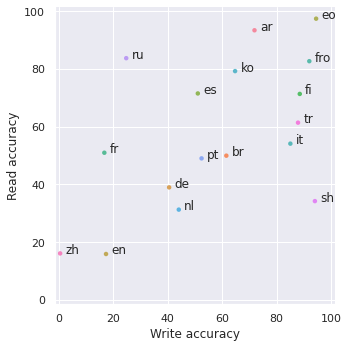

<Figure size 504x504 with 0 Axes>

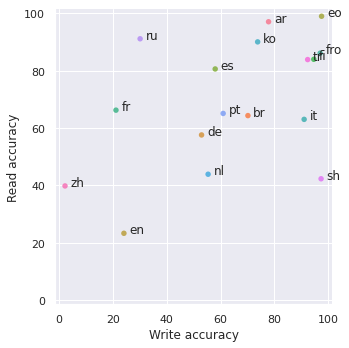

<Figure size 504x504 with 0 Axes>

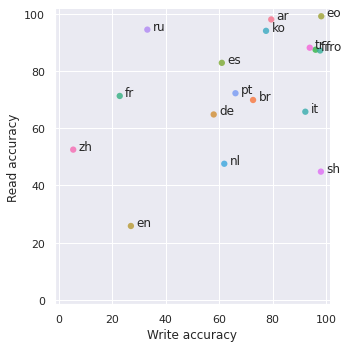

<Figure size 504x504 with 0 Axes>

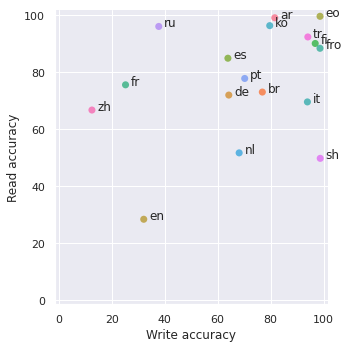

<Figure size 504x504 with 0 Axes>

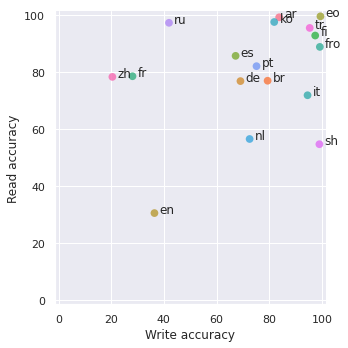

<Figure size 504x504 with 0 Axes>

In [19]:
n_trains = [1000, 2000, 3000, 5000, 10000]


for n_train in n_trains:
    config['n_train'] = n_train
    config = extend_config(config)
    display_colored_scatterplot_results(config)